🔧 Device: cuda
Loaded 288 images from C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET
Loaded 72 images from C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET_UNTUK_TEST_KLASIFIKASI
Arsitektur Baru Berhasil Dibuat

 MULAI TRAINING...
Epoch [01] T-Loss: 1.2215 | V-Acc: 37.50% Saved!
Epoch [02] T-Loss: 1.1670 | V-Acc: 37.50% 
Epoch [03] T-Loss: 1.1029 | V-Acc: 37.50% 
Epoch [04] T-Loss: 1.0821 | V-Acc: 43.06% Saved!
Epoch [05] T-Loss: 1.0145 | V-Acc: 37.50% 
Epoch [06] T-Loss: 0.8816 | V-Acc: 33.33% 
Epoch [07] T-Loss: 0.8379 | V-Acc: 33.33% 
Epoch [08] T-Loss: 0.7484 | V-Acc: 34.72% 
Epoch [09] T-Loss: 0.7574 | V-Acc: 37.50% 
Epoch [10] T-Loss: 0.7340 | V-Acc: 62.50% Saved!
Epoch [11] T-Loss: 0.7139 | V-Acc: 61.11% 
Epoch [12] T-Loss: 0.7199 | V-Acc: 69.44% Saved!
Epoch [13] T-Loss: 0.7256 | V-Acc: 73.61% Saved!
Epoch [14] T-Loss: 0.7113 | V-Acc: 73.61% 
Epoch [15] T-Loss: 0.6814 | V-Acc: 69.44% 
Epoch [16] T-Loss: 0.7061 | V-Acc: 72.22% 
Epoch [17] T-Loss: 0.7330 | V-Acc: 68.06% 
Ep

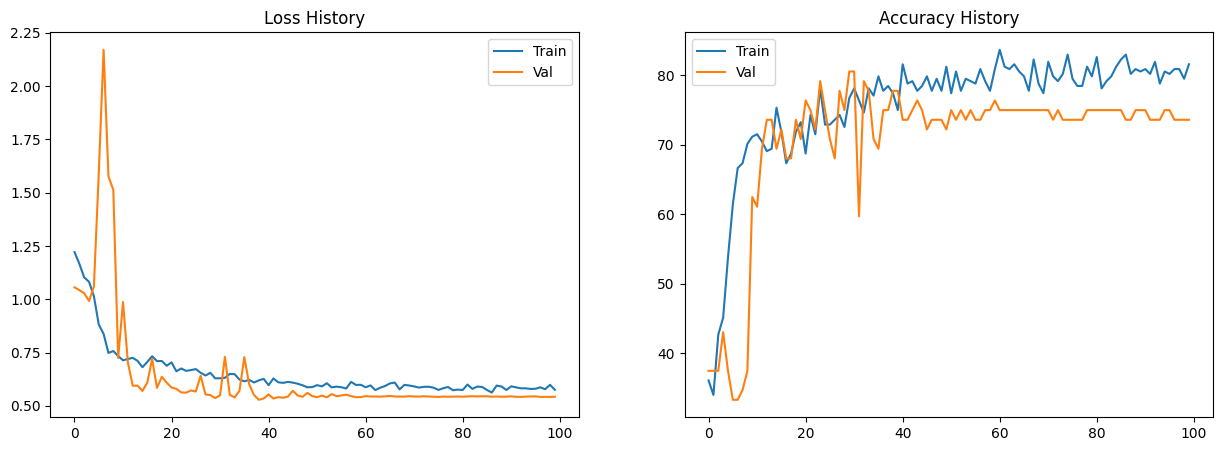

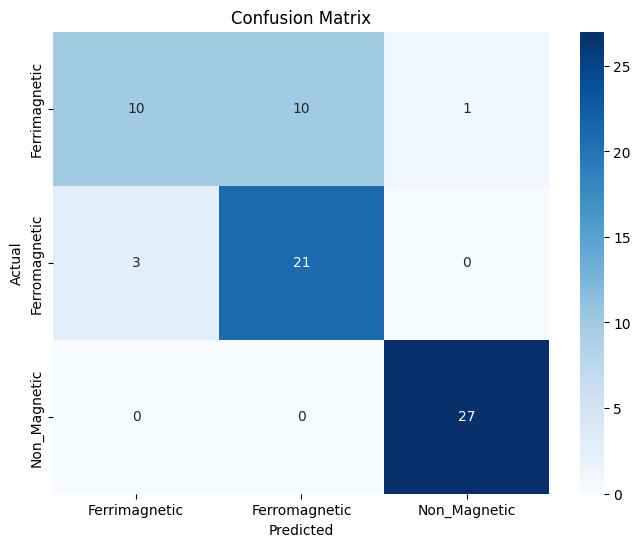

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import time

TRAIN_DIR = r"C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET"
VAL_DIR = r"C:\Riset Skripsi\DATASET_ASLI\DATA_MASK_HASIL_UNET_UNTUK_TEST_KLASIFIKASI"

BATCH_SIZE = 32
LEARNING_RATE = 0.0005 
NUM_EPOCHS = 100       
IMG_SIZE = 128        

CLASSES = ["Ferrimagnetic", "Ferromagnetic", "Non_Magnetic"]
NUM_CLASSES = len(CLASSES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔧 Device: {device}")

class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        
        for idx, class_name in enumerate(CLASSES):
            class_path = os.path.join(root_dir, class_name)
            if not os.path.exists(class_path):
                print(f"Warning: {class_path} tidak ditemukan!")
                continue
            
            for filename in os.listdir(class_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.data.append(os.path.join(class_path, filename))
                    self.labels.append(idx)
        
        print(f"Loaded {len(self.data)} images from {root_dir}")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L') 
        
        if self.transform:
            image = self.transform(image)
        return image, label

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = MaskDataset(TRAIN_DIR, transform=train_transform)
val_dataset = MaskDataset(VAL_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(EnhancedCNN, self).__init__()
        
        def conv_block(in_f, out_f):
            return nn.Sequential(
                nn.Conv2d(in_f, out_f, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_f),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Conv2d(out_f, out_f, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_f),
                nn.LeakyReLU(0.1, inplace=True),
                nn.MaxPool2d(2, 2)
            )

        self.features = nn.Sequential(
            conv_block(1, 32),   
            conv_block(32, 64),  
            conv_block(64, 128), 
            conv_block(128, 256) 
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

model = EnhancedCNN(num_classes=NUM_CLASSES).to(device)
print(f"Arsitektur Baru Berhasil Dibuat")

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# ===== 6. TRAIN & VALIDATE FUNCTIONS =====
def run_epoch(model, loader, criterion, optimizer, device, is_train=True):
    if is_train: model.train()
    else: model.eval()
    
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    
    with torch.set_grad_enabled(is_train):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            if is_train: optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            if is_train:
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if not is_train:
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
    return running_loss/len(loader), 100.*correct/total, all_preds, all_labels

# ===== 7. TRAINING LOOP =====
print("\n MULAI TRAINING...")
train_losses, train_accs, val_losses, val_accs = [], [], [], []
best_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    t_loss, t_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer, device, True)
    v_loss, v_acc, preds, truths = run_epoch(model, val_loader, criterion, None, device, False)
    
    scheduler.step(v_loss)
    
    train_losses.append(t_loss); train_accs.append(t_acc)
    val_losses.append(v_loss); val_accs.append(v_acc)
    
    if v_acc > best_acc:
        best_acc = v_acc
        torch.save(model.state_dict(), 'best_model.pth')
        save_msg = "Saved!"
    else: save_msg = ""
    
    print(f"Epoch [{epoch:02d}] T-Loss: {t_loss:.4f} | V-Acc: {v_acc:.2f}% {save_msg}")

print("\n EVALUASI AKHIR...")
model.load_state_dict(torch.load('best_model.pth'))
_, final_acc, y_pred, y_true = run_epoch(model, val_loader, criterion, None, device, False)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label='Train'); ax1.plot(val_losses, label='Val')
ax1.set_title('Loss History'); ax1.legend()
ax2.plot(train_accs, label='Train'); ax2.plot(val_accs, label='Val')
ax2.set_title('Accuracy History'); ax2.legend()
plt.savefig('history.png')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.savefig('cm.png')

print("\n" + "="*40)
print(classification_report(y_true, y_pred, target_names=CLASSES))
print(f" Best Validation Accuracy: {best_acc:.2f}%")
print("="*40)